In [1]:
import sys
sys.path.append("../")
from clapton.clapton import claptonize, claptonize_opt
from clapton.ansatzes import circular_ansatz
from clapton.utils import Results
import numpy as np
import pickle
import time
import copy


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.problems import ElectronicStructureProblem

/clusterfs/students/santana/clapton/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exact_results = Results("exact")
GA_results = Results("GA")
optuna_results = Results("optuna")


In [ ]:
hamiltonian_strings = [f"H 0 0 0; H 0 0 {bond_length :.3f}" for bond_length in np.arange(0.37, 3.0, 0.1)]
print(hamiltonian_strings)

for i, hamiltonian_string in enumerate(hamiltonian_strings):
    print(f"=================================")
    print(f"Starting {i+1}/{len(hamiltonian_strings)}: {hamiltonian_string}")
    print(f"=================================")
    driver = PySCFDriver(atom=hamiltonian_string, basis="sto-3g")
    problem = driver.run()
    second_q_op = problem.hamiltonian.second_q_op()

    mapper = ParityMapper()
    qubit_op = mapper.map(second_q_op)

    paulis_ = qubit_op.paulis.to_labels()
    coeffs_ = qubit_op.coeffs
    
    if np.all(np.abs(coeffs_.imag) < 1e-10) is False:
        print(f"Skipping {hamiltonian_string} due to complex coefficients.")
        continue

    numpy_solver = NumPyMinimumEigensolver()
    calc = GroundStateEigensolver(mapper, numpy_solver)

    exact_time = time.time()
    res = calc.solve(problem)
    exact_time = time.time() - exact_time
    exact_results.add_result(hamiltonian_string, paulis_, coeffs_.real.astype(float).tolist(), exact_time, 0, float(res.groundenergy))
    
    
    #############################
    
    coeffs_ = coeffs_.real.astype(float)

    vqe_pcirc_ = circular_ansatz(N=len(paulis_[0]), reps=1, fix_2q=True)


    vqe_pcirc = copy.deepcopy(vqe_pcirc_)
    paulis = copy.deepcopy(paulis_)
    coeffs = copy.deepcopy(coeffs_)

    GA_time = time.time()
    ks_best, _, energy_best = claptonize(
        paulis,
        coeffs,
        vqe_pcirc,
        n_proc=4,           # total number of processes in parallel
        n_starts=4,         # number of random genetic algorithm starts in parallel
        n_rounds=1,         # number of budget rounds, if None it will terminate itself
        # callback=print,     # callback for internal parameter (#iteration, energies, ks) processing
        budget=20           # budget per genetic algorithm instance
    )
    GA_time = time.time() - GA_time

    GA_results.add_result(hamiltonian_string, paulis, coeffs.tolist(), GA_time, ks_best, float(energy_best))

    vqe_pcirc = copy.deepcopy(vqe_pcirc_)
    paulis = copy.deepcopy(paulis_)
    coeffs = copy.deepcopy(coeffs_)

    optuna_time = time.time()
    ks_best, _, energy_best = claptonize_opt(
        paulis,
        coeffs,
        vqe_pcirc,
    )
    optuna_time = time.time() - optuna_time
    optuna_results.add_result(hamiltonian_string, paulis, coeffs.tolist(), optuna_time, ks_best, float(energy_best))
    
    
    

    with open("results/exact", "wb") as file:
        pickle.dump(exact_results, file)
    with open("results/GA", "wb") as file:
        pickle.dump(GA_results, file)
    with open("results/optuna", "wb") as file:
        pickle.dump(optuna_results, file)
        

['H 0 0 0; H 0 0 0.370', 'H 0 0 0; H 0 0 0.470', 'H 0 0 0; H 0 0 0.570', 'H 0 0 0; H 0 0 0.670', 'H 0 0 0; H 0 0 0.770', 'H 0 0 0; H 0 0 0.870', 'H 0 0 0; H 0 0 0.970', 'H 0 0 0; H 0 0 1.070', 'H 0 0 0; H 0 0 1.170', 'H 0 0 0; H 0 0 1.270', 'H 0 0 0; H 0 0 1.370', 'H 0 0 0; H 0 0 1.470', 'H 0 0 0; H 0 0 1.570', 'H 0 0 0; H 0 0 1.670', 'H 0 0 0; H 0 0 1.770', 'H 0 0 0; H 0 0 1.870', 'H 0 0 0; H 0 0 1.970', 'H 0 0 0; H 0 0 2.070', 'H 0 0 0; H 0 0 2.170', 'H 0 0 0; H 0 0 2.270', 'H 0 0 0; H 0 0 2.370', 'H 0 0 0; H 0 0 2.470', 'H 0 0 0; H 0 0 2.570', 'H 0 0 0; H 0 0 2.670', 'H 0 0 0; H 0 0 2.770', 'H 0 0 0; H 0 0 2.870', 'H 0 0 0; H 0 0 2.970']
Starting 1/27: H 0 0 0; H 0 0 0.370


NameError: name 'paulis' is not defined

In [ ]:
print(optuna_results)
print(GA_results)

Name: optuna
  Hamiltonian: ['H 0 0 0; H 0 0 0.370', 'H 0 0 0; H 0 0 0.470', 'H 0 0 0; H 0 0 0.570', 'H 0 0 0; H 0 0 0.670', 'H 0 0 0; H 0 0 0.770', 'H 0 0 0; H 0 0 0.870', 'H 0 0 0; H 0 0 0.970', 'H 0 0 0; H 0 0 1.070', 'H 0 0 0; H 0 0 1.170', 'H 0 0 0; H 0 0 1.270', 'H 0 0 0; H 0 0 1.370', 'H 0 0 0; H 0 0 1.470', 'H 0 0 0; H 0 0 1.570', 'H 0 0 0; H 0 0 1.670', 'H 0 0 0; H 0 0 1.770', 'H 0 0 0; H 0 0 1.870', 'H 0 0 0; H 0 0 1.970', 'H 0 0 0; H 0 0 2.070', 'H 0 0 0; H 0 0 2.170', 'H 0 0 0; H 0 0 2.270', 'H 0 0 0; H 0 0 2.370', 'H 0 0 0; H 0 0 2.470', 'H 0 0 0; H 0 0 2.570', 'H 0 0 0; H 0 0 2.670', 'H 0 0 0; H 0 0 2.770', 'H 0 0 0; H 0 0 2.870', 'H 0 0 0; H 0 0 2.970']
  Paulis: [['IIII', 'IIIZ', 'IIZZ', 'IIZI', 'IZZI', 'IZZZ', 'ZZII', 'ZZIZ', 'ZXIX', 'IXZX', 'ZXZX', 'IXIX', 'IZIZ', 'ZZZZ', 'ZIZI'], ['IIII', 'IIIZ', 'IIZZ', 'IIZI', 'IZZI', 'IZZZ', 'ZZII', 'ZZIZ', 'ZXIX', 'IXZX', 'ZXZX', 'IXIX', 'IZIZ', 'ZZZZ', 'ZIZI'], ['IIII', 'IIIZ', 'IIZZ', 'IIZI', 'IZZI', 'IZZZ', 'ZZII', 'ZZIZ', 'ZX

# Plotting

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "ieee"])

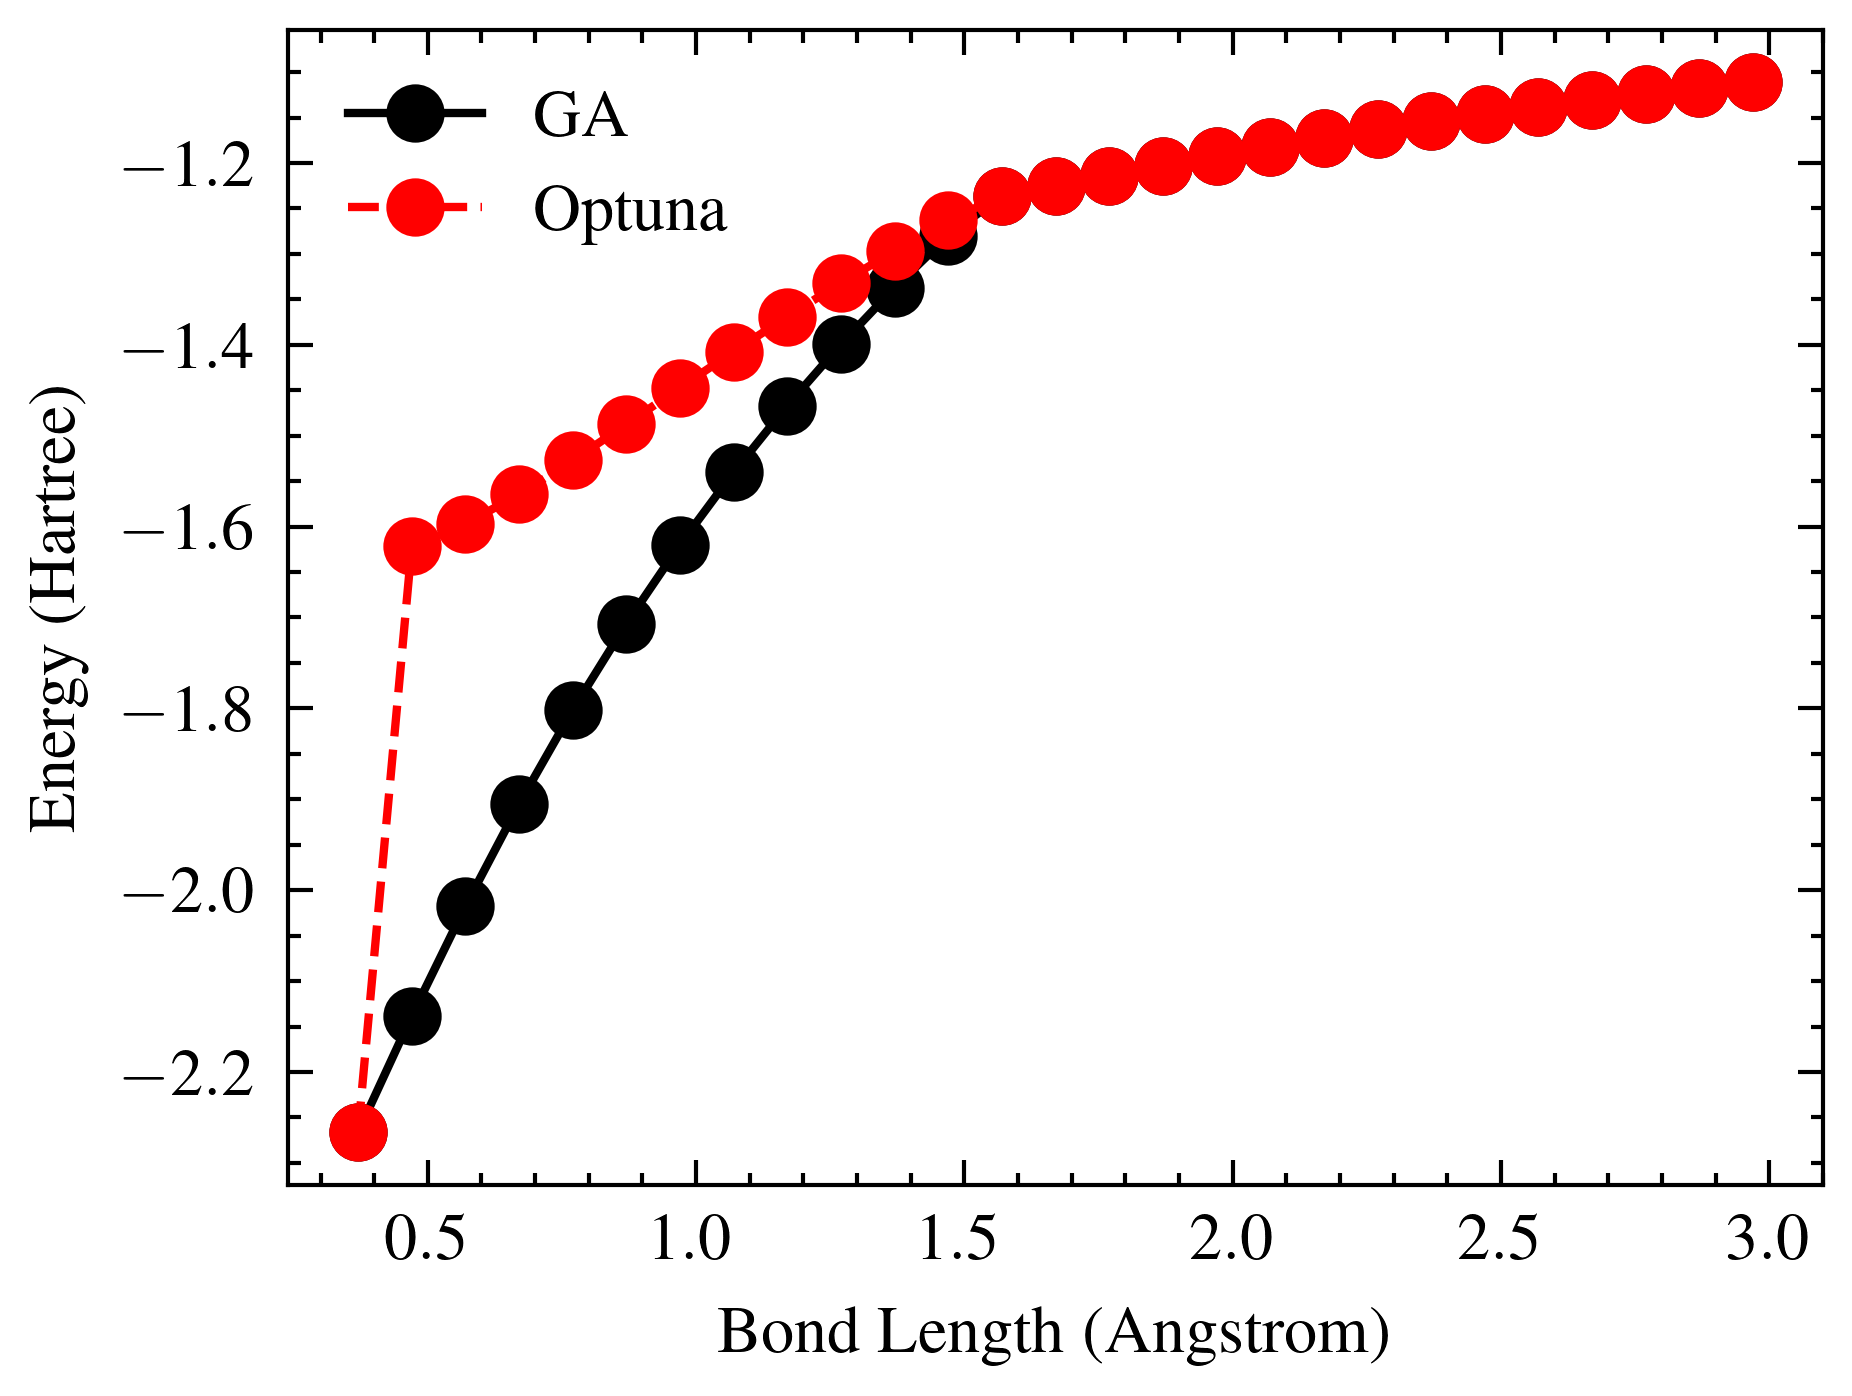

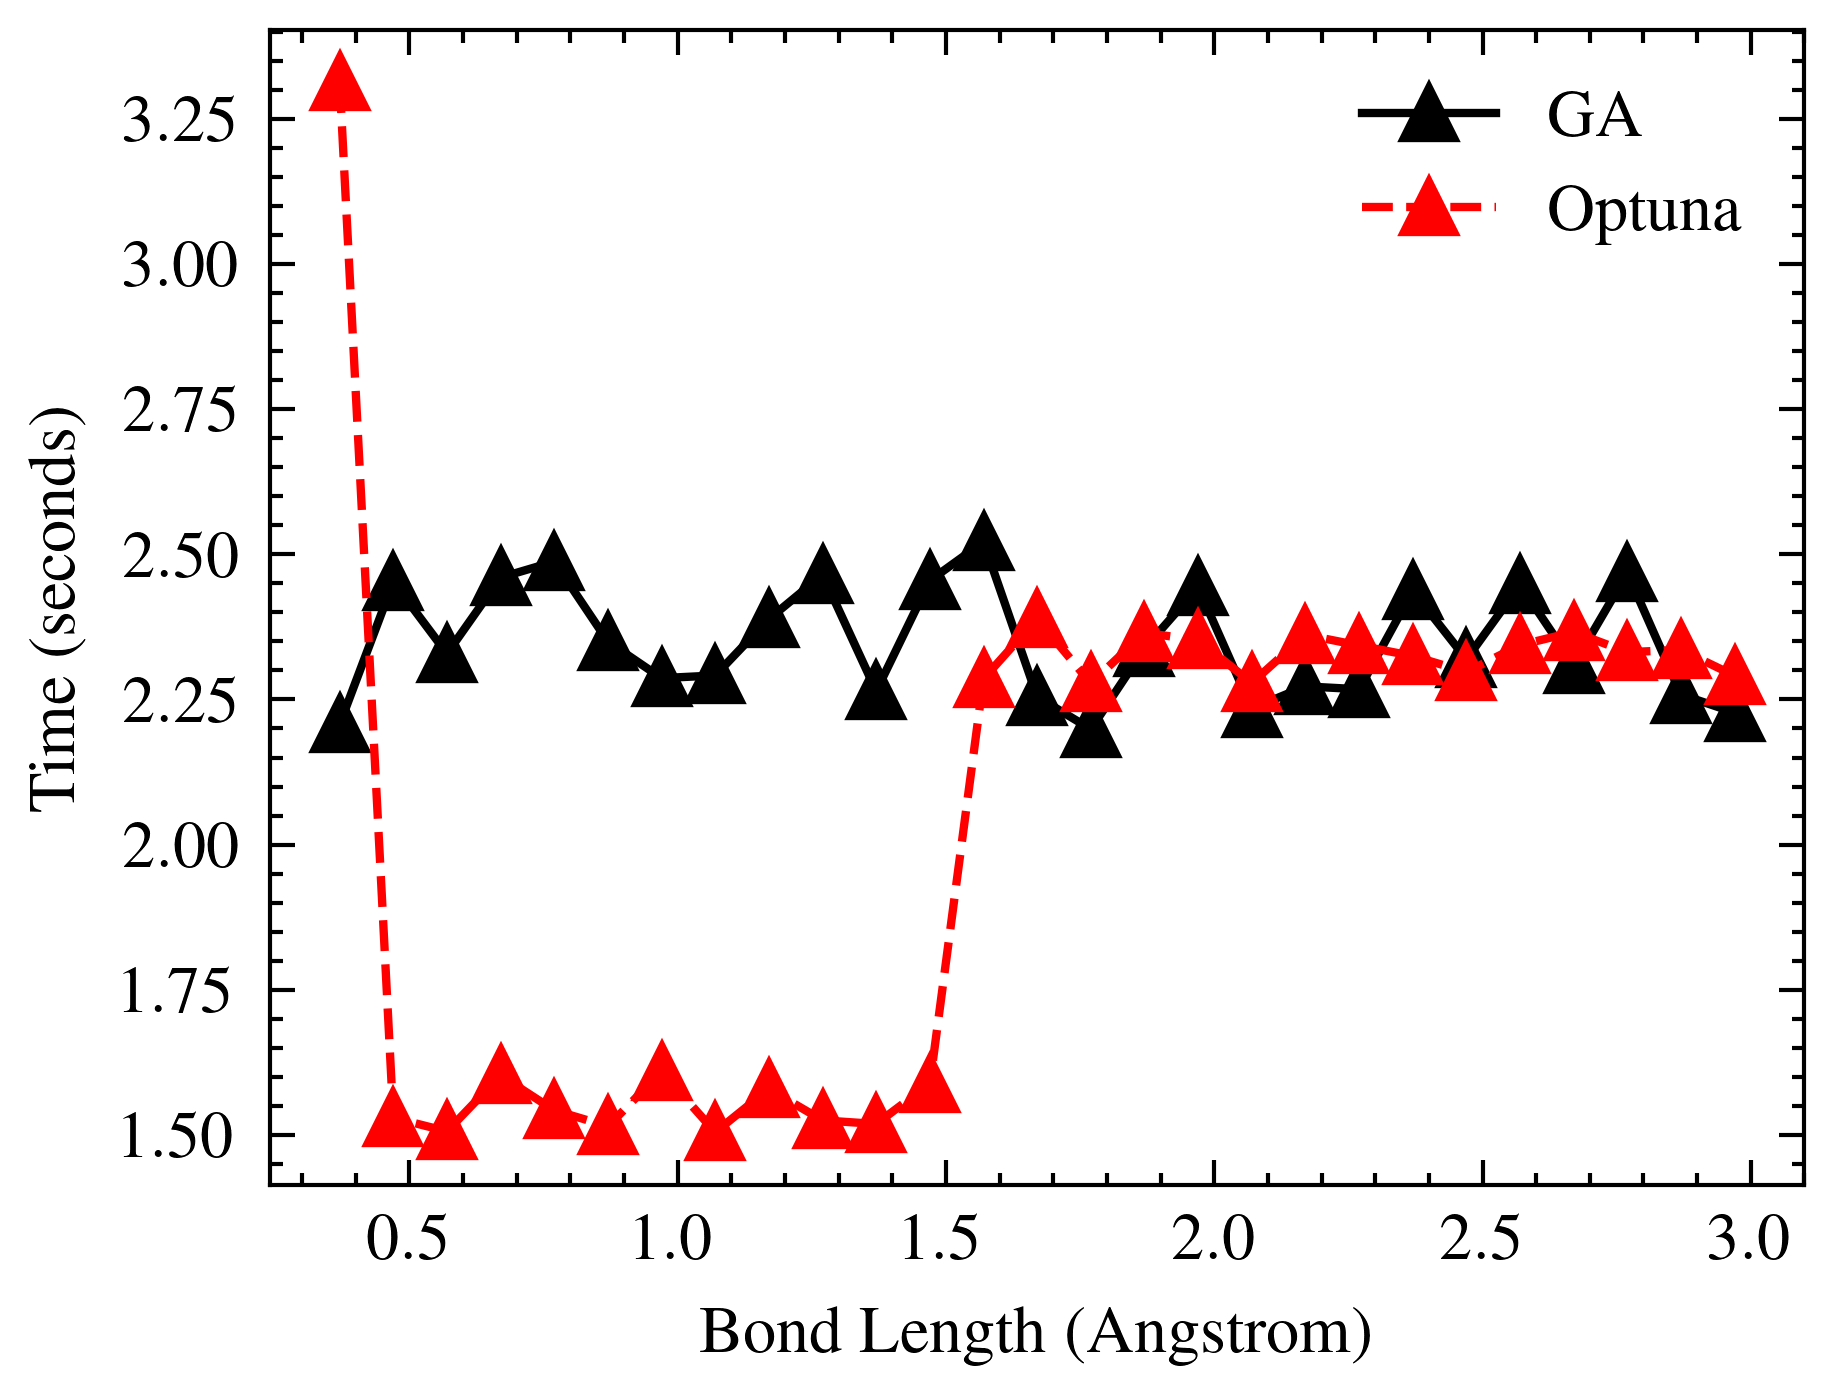

<Figure size 1980x1500 with 0 Axes>

In [ ]:
plt.plot(GA_results.bond_lengths, GA_results.energy_bests, label="GA", marker="o")
plt.plot(optuna_results.bond_lengths, optuna_results.energy_bests, label="Optuna", marker="o")
plt.plot(exact_results.bond_lengths, exact_results.energy_bests, label="Exact", marker="o")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()
plt.clf()


plt.plot(GA_results.bond_lengths, GA_results.times, label="GA", marker="^")
plt.plot(optuna_results.bond_lengths, optuna_results.times, label="Optuna", marker="^")
plt.plot(exact_results.bond_lengths, exact_results.times, label="Exact", marker="^")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()
plt.clf()

